In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pyaurorax

aurorax = pyaurorax.PyAuroraX()

# TREx-ATM Forward Calculation with both custom spectrum and neutral profile

We can also supply both a custom spectrum and a neutral profile. For more information about each, refer to their individual respective crib sheets.

Complete documentation describing all caveats can be found in the [`forward()`](https://docs.aurorax.space/code/pyaurorax_api_reference/pyaurorax/models/atm/index.html) function's docs.

In [2]:
# Set up custom spectrum
#
ef_count = 11  # number of energy and flux values we want to have
custom_spectrum_arr = np.zeros((2, ef_count), order='F', dtype=np.single)  # 2-D array, first dimension will be energy, second will be flux
for i in range(ef_count):
    custom_spectrum_arr[0, i] = 4000. + i * 100.
    custom_spectrum_arr[1, i] = 1e6

In [3]:
# Set up custom neutral profile
#
# Input is a 7 x num_neut array
#   - The first row is the altitude (kilometers)
#   - The 2nd to 6th rows are the densities of O, O2, N2, N, NO (cm^-3)
#   - The 7th row is the neutral temperature (Kelvin)
num_neut = 16
custom_neutral_profile_arr = np.zeros((7, num_neut), order='F', dtype=np.single)
for i in range(num_neut):
    custom_neutral_profile_arr[0, i] = 50. + i * 50.
    custom_neutral_profile_arr[2, i] = 1e16 * np.exp(-2. * i)
    custom_neutral_profile_arr[3, i] = 2.5e15 * np.exp(-2. * i)
    custom_neutral_profile_arr[4, i] = 1e6
    custom_neutral_profile_arr[5, i] = 1e6
    custom_neutral_profile_arr[6, i] = 200. + i * 50.

    if i < 1:
        custom_neutral_profile_arr[1, i] = 1e9
    else:
        custom_neutral_profile_arr[1, i] = 1e10 * np.exp(-1. * (i - 1.))

In [4]:
# set parameters
timestamp = datetime.datetime(2021, 11, 4, 6, 0, 0)
latitude = 53.1
longitude = -107.7

# set output flags
output = pyaurorax.models.ATMForwardOutputFlags()
output.set_all_true()

# run model
result = aurorax.models.atm.forward(timestamp,
                                    latitude,
                                    longitude,
                                    output,
                                    custom_spectrum=custom_spectrum_arr,
                                    custom_neutral_profile=custom_neutral_profile_arr)

# show results
result.pretty_print()

ATMForwardResult:
  altitudes                                  : array([ 80. ,  81. ,  82. ,  83. ,  84. ,  85. ,  86. ,  87. ...])
  emission_1304                              : array([4.75274938e-22, 4.97674498e-22, 5.42401119e-22, 5.911 ...])
  emission_1356                              : array([9.16358814e-23, 9.59547812e-23, 1.04579013e-22, 1.139 ...])
  emission_4278                              : array([1.43029785e-17, 1.37421012e-17, 1.37421972e-17, 1.374 ...])
  emission_5577                              : array([1.52482519e-12, 1.17377757e-11, 5.64282301e-11, 2.032 ...])
  emission_6300                              : array([1.41437409e-11, 1.47833239e-11, 1.54757648e-11, 1.625 ...])
  emission_8446                              : array([1.17113613e-17, 1.12521751e-17, 1.12522777e-17, 1.125 ...])
  emission_smile_uvi_lbh                     : array([6.64771816e-19, 6.38705184e-19, 6.38709526e-19, 6.387 ...])
  height_integrated_rayleighs_1304           : 12.589472
  height_inte

Height-integrated Rayleighs:
  427.8nm:        433.78 R
  557.7nm:        6957.32 R
  630.0nm:        943.23 R
  844.6nm:        361.30 R
  130.4nm:        12.59 R
  135.6nm:        2.41 R
  SMILE UVI LBH:  20.09 R


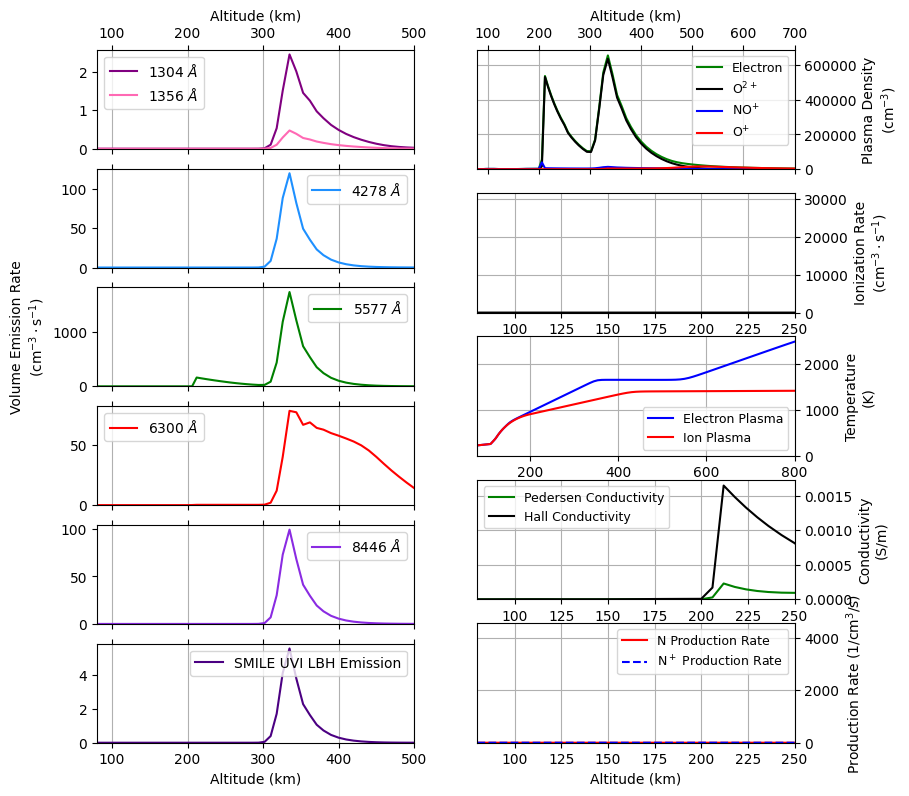

In [5]:
# now let's have a closer look at everything we got back
#
# print all height-integrated Rayleighs data
print("""Height-integrated Rayleighs:
  427.8nm:        %.02f R
  557.7nm:        %.02f R
  630.0nm:        %.02f R
  844.6nm:        %.02f R
  130.4nm:        %.02f R
  135.6nm:        %.02f R
  SMILE UVI LBH:  %.02f R""" %
      (result.height_integrated_rayleighs_4278, result.height_integrated_rayleighs_5577, result.height_integrated_rayleighs_6300,
       result.height_integrated_rayleighs_8446, result.height_integrated_rayleighs_1304, result.height_integrated_rayleighs_1356,
       result.height_integrated_rayleighs_smile_uvi_lbh))

# plot the emission, plasma, and neutral data
#
# we'll do this all in one plot, but made up from many subplots
alt = result.altitudes
fig = plt.figure(figsize=(9, 9))

# plot all the emissions as a column of subplots
#
# 1304 A & 1356 A emission
ax1 = fig.add_subplot(6, 2, 1)
ax1.plot(alt, result.emission_1304, label=r"1304 $\AA$", color="purple")
ax1.plot(alt, result.emission_1356, label=r"1356 $\AA$", color="hotpink")
ax1.legend()
ax1.set_xlim(80, 500)
ax1.set_ylim(bottom=0)
ax1.grid(axis="x")
ax1.set_xlabel("Altitude (km)", va="bottom")
ax1.tick_params(axis="x", bottom=True, top=True, labeltop=True, labelbottom=False)
ax1.xaxis.set_label_position("top")

# blueline emission
ax2 = fig.add_subplot(6, 2, 3)
ax2.plot(alt, result.emission_4278, label=r"4278 $\AA$", color="dodgerblue")
ax2.legend()
ax2.set_xlim(80, 500)
ax2.set_ylim(bottom=0)
ax2.grid(axis="x")
ax2.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# greenline emission
ax3 = fig.add_subplot(6, 2, 5)
ax3.plot(alt, result.emission_5577, label=r"5577 $\AA$", color="green")
ax3.legend()
ax3.set_xlim(80, 500)
ax3.set_ylim(bottom=0)
ax3.grid(axis="x")
ax3.set_ylabel("Volume Emission Rate\n(cm$^{-3} \cdot $s$^{-1}$)")
ax3.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# redline emission
ax4 = fig.add_subplot(6, 2, 7)
ax4.plot(alt, result.emission_6300, label=r"6300 $\AA$", color="red")
ax4.legend()
ax4.set_xlim(80, 500)
ax4.set_ylim(bottom=0)
ax4.grid(axis="x")
ax4.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# near-infrared 8446 A emission
ax5 = fig.add_subplot(6, 2, 9)
ax5.plot(alt, result.emission_8446, label=r"8446 $\AA$", color="blueviolet")
ax5.legend()
ax5.set_xlim(80, 500)
ax5.set_ylim(bottom=0)
ax5.grid(axis="x")
ax5.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# Lyman-Birge-Hopfield emission (derived by integrating SMILE UVI filter into the ATM model)
ax6 = fig.add_subplot(6, 2, 11)
ax6.plot(alt, result.emission_smile_uvi_lbh, label="SMILE UVI LBH Emission", color="indigo")
ax6.legend()
ax6.set_xlim(80, 500)
ax6.set_ylim(bottom=0)
ax6.grid(axis="x")
ax6.set_xlabel("Altitude (km)")
ax6.tick_params(axis="x", bottom=True, top=True)

# plot the plasma data as a second column of subplots
#
# plasma density
ax7 = fig.add_subplot(5, 2, 2)
ax7.plot(alt, result.plasma_electron_density, label="Electron", color="green")
ax7.plot(alt, result.plasma_o2plus_density, label="O$^{2+}$", color="black")
ax7.plot(alt, result.plasma_noplus_density, label="NO$^{+}$", color="blue")
ax7.plot(alt, result.plasma_oplus_density, label="O$^{+}$", color="red")
ax7.grid()
ax7.set_ylabel("Plasma Density\n(cm$^{-3}$)")
ax7.legend(fontsize=9)
ax7.set_xlim(80, 700)
ax7.set_ylim(bottom=0)
ax7.tick_params(axis="x", bottom=True, top=True, labeltop=True, labelbottom=False)
ax7.set_xlabel("Altitude (km)")
ax7.xaxis.set_label_position("top")
ax7.yaxis.set_label_position("right")
ax7.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma ionisation rate
ax8 = fig.add_subplot(5, 2, 4)
ax8.plot(alt, result.plasma_ionisation_rate, color="black")
ax8.grid()
ax8.set_ylabel("Ionization Rate\n(cm$^{-3} \cdot $s$^{-1}$)")
ax8.set_xlim(80, 250)
ax8.set_ylim(bottom=0)
ax8.yaxis.set_label_position("right")
ax8.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma temperatures
ax9 = fig.add_subplot(5, 2, 6)
ax9.plot(alt, result.plasma_electron_temperature, label="Electron Plasma", color="blue")
ax9.plot(alt, result.plasma_ion_temperature, label="Ion Plasma", color="red")
ax9.grid()
ax9.legend(fontsize=9)
ax9.set_ylabel("Temperature\n(K)")
ax9.set_xlim(80, 800)
ax9.set_ylim(bottom=0)
ax9.yaxis.set_label_position("right")
ax9.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma conductivities
ax10 = fig.add_subplot(5, 2, 8)
ax10.plot(alt, result.plasma_pedersen_conductivity, label="Pedersen Conductivity", color="green")
ax10.plot(alt, result.plasma_hall_conductivity, label="Hall Conductivity", color="black")
ax10.grid()
ax10.legend(fontsize=9)
ax10.set_ylabel("Conductivity\n(S/m)")
ax10.set_xlim(80, 250)
ax10.set_ylim(bottom=0)
ax10.set_xlabel("Altitude (km)")
ax10.yaxis.set_label_position("right")
ax10.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# some production rates
ax10 = fig.add_subplot(5, 2, 10)
ax10.plot(alt, result.production_rate_n, label="N Production Rate", color="red")
ax10.plot(alt, result.production_rate_nplus, label="N$^+$ Production Rate", color="blue", linestyle="--")
ax10.grid()
ax10.legend(fontsize=9)
ax10.set_ylabel("Production Rate (1/cm$^3$/s)")
ax10.set_xlim(80, 250)
ax10.set_ylim(bottom=0)
ax10.set_xlabel("Altitude (km)")
ax10.yaxis.set_label_position("right")
ax10.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# render the plot
plt.show()